In [ ]:
import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
BATCH_SIZE = 64
EPOCHS = 10
LSTM_NODES =256
NUM_SENTENCES = 11668
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 15000
EMBEDDING_SIZE = 300

In [ ]:
!!curl -O http://www.manythings.org/anki/ara-eng.zip
!!unzip ara-eng.zip

['Archive:  ara-eng.zip',
 '  inflating: _about.txt              ',
 '  inflating: ara.txt                 ']

In [ ]:
f = open("/content/ara.txt", "r")
g = open("/content/fixed_ara.txt", "w")

for line in f:
    if line.strip():
        g.write("\t".join(line.split('\t')[:2]) + "\n")

f.close()
g.close()

In [ ]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []

count = 0
for line in open(r'/content/fixed_ara.txt', encoding="utf-8"):
    count += 1

    if count > NUM_SENTENCES:
        break

    if '\t' not in line:
        continue

    input_sentence, output = line.rstrip().split('\t')

    output_sentence = output + ' <eos>'
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("num samples input:", len(input_sentences))
print("num samples output:", len(output_sentences))
print("num samples output input:", len(output_sentences_inputs))

num samples input: 11668
num samples output: 11668
num samples output input: 11668


In [ ]:
print(input_sentences[10])
print(output_sentences[10])
print(output_sentences_inputs[10])

I see.
انا اري <eos>
<sos> انا اري


In [ ]:
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

Total unique words in the input: 4270
Length of longest sentence in input: 34


In [ ]:
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

Total unique words in the output: 14792
Length of longest sentence in the output: 37


In [ ]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[10]:", encoder_input_sequences[10])

encoder_input_sequences.shape: (11668, 34)
encoder_input_sequences[10]: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  1 87]


In [ ]:
print(word2idx_inputs["of"])
print(word2idx_inputs["course"])

15
786


In [ ]:
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[10]:", decoder_input_sequences[10])

decoder_input_sequences.shape: (11668, 37)
decoder_input_sequences[10]: [   2  147 5149    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]


In [ ]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')

In [ ]:
print(word2idx_outputs["<eos>"])
print(word2idx_outputs["طبعاً!"])

1
2934


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-05-02 18:48:27--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-05-02 18:48:27--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-05-02 18:48:27--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
import numpy as np
embeddings_index = {}
with open('/content/glove.6B.300d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open(r'/content/glove.6B.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [ ]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
print(embeddings_dictionary["course"])


[-0.52371   -0.44083    0.34225    0.41064   -0.21218    0.03431
 -0.021856   0.097563   0.35585   -1.5093     0.30294    0.22135
  0.16906    0.043339   0.062974  -0.11252    0.2818     0.15375
  0.60427    0.61581   -0.075057  -0.24214    0.0099421  0.45133
 -0.73914    0.11561   -0.11896   -0.17089   -0.25271   -0.4846
  0.24009   -0.16476    0.17586   -0.093761  -0.82693    0.63186
 -0.26915   -0.53539   -0.22293    0.044449  -0.19434   -0.23717
 -0.095677  -0.36154    0.25425    0.25551    0.3146     0.64131
  0.1786    -0.13662   -0.47772   -0.53688    0.30732    0.46526
  0.13306    0.6245    -0.021982  -0.016591   0.55766    0.090356
  0.48976   -0.086931   0.26188    0.28274   -0.20054   -0.11525
  0.26347    0.10177   -0.49173   -0.4455    -0.0050688  0.18205
  0.12029   -0.034127   0.06195   -0.09392   -0.060547   0.094898
 -0.33962   -0.15461   -0.24351   -0.036829   0.038934   0.035064
  0.096655   0.10474   -0.23622    0.053082   0.092839  -0.10973
  0.088191   0.17939   

In [ ]:
print(embedding_matrix[539])

[ 0.019932   -0.022283   -0.51384997 -0.2173      0.25782999 -0.15474001
 -0.025695   -0.17854001  0.060605   -0.13778    -0.38782001  0.01563
  0.090285   -0.028052    0.37371999  0.057938    0.50853997 -0.33333001
  0.016994    0.43029001  0.37244999  0.35350999 -0.074267   -0.43022999
 -0.41376001 -0.35370001 -0.069673    0.29756001  0.14442    -0.35844001
  0.093499    0.024201   -0.30667001 -0.034969   -0.74571002 -0.30057999
 -0.09542     0.032652   -0.091006   -0.17101     0.1485     -0.73762
  0.33634999  0.16632999  0.17437001  0.114       0.38117    -0.33017001
 -0.083412    0.40558001  0.43935999  0.018723   -0.096614    0.044401
 -0.48622999  0.31257999  0.73701    -0.18081     0.51621002  0.58227003
  0.17181    -0.08246    -0.3743      0.55331999  0.15206     0.10194
  0.17937     0.31771001  0.14802    -0.24894001  0.17577    -0.44622001
  0.079147    0.56257999  0.22247    -0.58844    -0.18028     0.064491
 -0.14151999 -0.32385001 -0.1735      0.51854998  0.6627     -0.

In [ ]:
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

In [ ]:
decoder_targets_one_hot = np.zeros((
        len(input_sentences),
        max_out_len,
        num_words_output
    ), dtype = 'uint8'
)

In [ ]:
decoder_targets_one_hot.shape

(11668, 37, 14793)

In [ ]:
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [ ]:
encoder_inputs_placeholder = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

In [ ]:
decoder_inputs_placeholder = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

In [ ]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
model = Model([encoder_inputs_placeholder,
  decoder_inputs_placeholder], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
r = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
)

Epoch 1/10
146/146 [==============================] - 51s 121ms/step - loss: 2.2141 - accuracy: 0.8462 - val_loss: 1.6552 - val_accuracy: 0.8168
Epoch 2/10
146/146 [==============================] - 16s 108ms/step - loss: 0.8011 - accuracy: 0.9019 - val_loss: 1.6016 - val_accuracy: 0.8211
Epoch 3/10
146/146 [==============================] - 16s 108ms/step - loss: 0.7440 - accuracy: 0.9057 - val_loss: 1.5755 - val_accuracy: 0.8236
Epoch 4/10
146/146 [==============================] - 16s 108ms/step - loss: 0.6883 - accuracy: 0.9093 - val_loss: 1.5429 - val_accuracy: 0.8263
Epoch 5/10
146/146 [==============================] - 16s 107ms/step - loss: 0.6441 - accuracy: 0.9126 - val_loss: 1.5206 - val_accuracy: 0.8284
Epoch 6/10
146/146 [==============================] - 16s 107ms/step - loss: 0.6033 - accuracy: 0.9165 - val_loss: 1.5207 - val_accuracy: 0.8294
Epoch 7/10
146/146 [==============================] - 16s 107ms/step - loss: 0.5626 - accuracy: 0.9203 - val_loss: 1.5000 - val_ac

In [ ]:
model.save_weights('SEQ2SEQ_weigths.h5')

In [ ]:
def plot_training_history(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']
    epochs = range(1, len(val_loss_values) + 1)

    plt.subplot(211)
    plt.plot(epochs, history.history['loss'], 'r', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Test loss')
    plt.title('Training and val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid('off')
    plt.show()

    plt.subplot(212)
    plt.plot(epochs, history.history['accuracy'], 'r', label='Training accuracy')
    plt.plot(epochs, val_acc_values, 'b', label='Val accuracy')
    plt.title('Training and val accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
    plt.legend()
    plt.grid('off')
    plt.show()

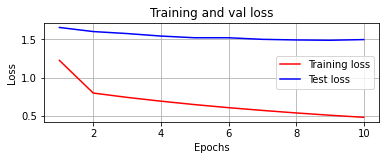

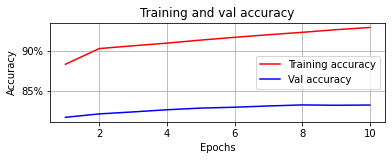

In [ ]:
plot_training_history(r)


In [ ]:
#We keep the encoder model as it was
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

In [ ]:
#Alter decoder to accept hidden state and cell state as inputs
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [ ]:
#One word as input at each timestep
#Alter decoder embedding for it
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [ ]:
#create variables to hold decoder LSTM outputs
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

In [ ]:
#Feed decoder output to dense layer
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
#Alter decoder model to accept single word + states + outputs
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

In [ ]:
#create reverse dictionary for both input and target seq
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [ ]:
#takes english seq in integer form and translates it to french using reverse dictionary
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1)) #placeholder for <sos> token
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx: #breaks if <eos> integer token encountered
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence) #concatenate words into sentence

In [ ]:
test = []
count= 0
for i in range(len(encoder_input_sequences)):
  input_seq = encoder_input_sequences[i:i+1]
  translation = translate_sentence(input_seq)
  test.append(translation.split())
  #print('-')
  #print('Input:', input_sentences[i])
  #print('Actual:', output_sentences[i][:-5])
  #print('Response:', translation)
  reference = np.array(output_sentences[i][:-5].split())
  trans = np.array(translation.split())
  ref = reference.reshape(1, -1)
  #print(ref)
  #print(trans)
  #print(sentence_bleu(ref, trans))
  count+=sentence_bleu(ref, trans)
print('\n')
print('Total BLEU Score:', count/len(encoder_input_sequences))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)




Total BLEU Score: 0.5749791846568767


In [ ]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Actual:', output_sentences[i][:-5])
print('Response:', translation)


-
Input: I think we can help each other.
Actual: اعتقد بأنه يمكننا مساعدة بعضنا البعض. 
Response: اعتقد بأنه يمكننا مساعدة البعض.


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
reference = np.array(output_sentences[i][:-5].split())
trans = np.array(translation.split())
ref = reference.reshape(1, -1)
print(ref)
print(trans)
sentence_bleu(ref, trans)

[['اعتقد' 'بأنه' 'يمكننا' 'مساعدة' 'بعضنا' 'البعض.']]
['اعتقد' 'بأنه' 'يمكننا' 'مساعدة' 'البعض.']


0.5789300674674098

In [ ]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

-
Input: They fell one after another.
Response: واحداً واحداً تلو الآخر.


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
reference = np.array(output_sentences[i][:-5].split())
trans = np.array(translation.split())
ref = reference.reshape(1, -1)
print(ref)
print(trans)
sentence_bleu(ref, trans)

[['وقعوا' 'واحداً' 'تلو' 'الآخر.']]
['واحداً' 'واحداً' 'تلو' 'الآخر.']


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.7071067811865476

In [ ]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

-
Input: It was a very big room.
Response: كان غرفة كبيرة.


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
reference = np.array(output_sentences[i][:-5].split())
trans = np.array(translation.split())
ref = reference.reshape(1, -1)
print(ref)
print(trans)
sentence_bleu(ref, trans)

[['كانت' 'غرفة' 'كبيرة.']]
['كان' 'غرفة' 'كبيرة.']


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.7598356856515925

In [ ]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

-
Input: It will rain tonight.
Response: ستمطر الليلة.


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
reference = np.array(output_sentences[i][:-5].split())
trans = np.array(translation.split())
ref = reference.reshape(1, -1)
print(ref)
print(trans)
sentence_bleu(ref, trans)

[['ستمطر' 'الليلة.']]
['ستمطر' 'الليلة.']


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


1.0

In [ ]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

-
Input: The war finally broke out.
Response: اِندلعت الحرب الحرب عام ١٩٣٩


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
reference = np.array(output_sentences[i][:-5].split())
trans = np.array(translation.split())
ref = reference.reshape(1, -1)
print(ref)
print(trans)
sentence_bleu(ref, trans)

[['اِندلعت' 'الحرب' 'أخيراً.']]
['اِندلعت' 'الحرب' 'الحرب' 'عام' '١٩٣٩']


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.5623413251903491

In [ ]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

-
Input: I've worked here for many years.
Response: لقد عملت هنا لمدة عديدة.


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
reference = np.array(output_sentences[i][:-5].split())
trans = np.array(translation.split())
ref = reference.reshape(1, -1)
print(ref)
print(trans)
sentence_bleu(ref, trans)

[['لقد' 'عملت' 'هنا' 'لسنوات' 'عديدة.']]
['لقد' 'عملت' 'هنا' 'لمدة' 'عديدة.']


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.6042750794713536